In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
from datetime import datetime
from pprint import pprint as pp
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact, IntSlider
import ipywidgets as widgets
import arrow

#import dmyplant2
from dmyplant2 import (
    cred, MyPlant, Engine, 
    msgFSM, filterFSM, FSM_splot, FSM_add_Notations, FSM_add_Alarms, FSM_add_Warnings, FSMPlot_Start, 
    bokeh_show, dbokeh_chart, add_dbokeh_vlines, get_cycle_data2, 
    disp_result, alarms_pareto, warnings_pareto, states_lines,
    detect_edge_right, detect_edge_left, cvset, load_data, get_cycle_data, get_cycle_data2)
    
cred()
mp = MyPlant(3600)
Engine._list_cached_validations();

In [2]:
def sfun(x):
    return all([ ("Pforzheim" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
    #return all([ ("BMW Landshut 4.10" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T

,0,1,2,3,4
Count_OpHour,2634.0,2558.0,2477.0,2405.0,2400.0
OperationalCondition,Running,Tripped,Running,Not Available,Running
shutdown_counter,278.0,305.0,306.0,223.0,205.0
startup_counter,248.0,261.0,280.0,218.0,203.0
id,136431,136740,136718,136558,136487
Engine Version,C101,C101,C101,C101,C101
Engine Type,920,920,920,920,920
Engine Series,9,9,9,9,9
Country,DE,DE,DE,DE,DE
Commissioning Date,2021-06-15,2021-06-15,2021-06-15,2021-06-14,2021-06-15


In [3]:
motor = fleet.iloc[0]
modes = ['???','OFF','MANUAL','AUTO']
success = [True,False]
#success = [True]
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success

('HKW Pforzheim M01', ['???', 'OFF', 'MANUAL', 'AUTO'], [True, False])

In [4]:
e=Engine.from_fleet(mp,motor)
#fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to='2019-01-16', successtime=300)
#fsm = msgFSM(e, p_to='2022-02-01', successtime=600)
#fsm = msgFSM(e, p_from='2022-01-26', p_to='2022-02-01', successtime=600)
fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to=datetime.now(), successtime=300)

In [5]:
fsm.run1(enforce=False, silent=False) # run Finite State Machine
#fsm.store()

FSM: 100%|█████████████████████| 157413/157413 [00:24<00:00, 6453.54 messages/s]


In [6]:
rdf = fsm.starts
rda = rdf[:].reset_index(drop='index')
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))].reset_index(drop='index')
display(HTML(pd.DataFrame.from_dict(e.dash, orient='index').T.to_html(escape=False, index=False)))
#rda[filterFSM.run2filter_content].round(2)
print(f"Starts: {rdf.shape[0]}, Successful: {rdf[rdf['success'] == True].shape[0]}, Failed: {rdf[rdf['success'] == False].shape[0]} => {rdf[rdf['success'] == True].shape[0]/rdf.shape[0]*100.0:3.1f}%")

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Na…

Starts: 212, Successful: 158, Failed: 54 => 74.5%


In [7]:
rda[filterFSM.run2filter_content].round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,0,True,AUTO,60.44,6.16,22.67,,18.09,277.78,385.14,,,369.3,0.51,88.51,,2,1
1,1,True,AUTO,22.42,5.28,13.41,,27.03,277.78,345.91,,,1046.39,128.99,0.1,89.9,1,1
2,2,False,AUTO,22.51,5.26,12.99,,28.55,145.33,214.64,,,,0.51,89.77,,2,2
3,3,True,AUTO,229.05,5.38,13.41,,15.32,277.78,540.95,,,7183.18,165.92,0.1,92.97,4,3
4,4,True,AUTO,60.38,6.07,14.59,,12.55,277.78,371.36,,,9557.97,154.41,0.0,92.5,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,207,True,AUTO,60.38,5.37,16.72,,24.03,277.78,384.28,,,13378.91,79.72,0.0,89.86,0,3
208,208,True,AUTO,60.44,5.57,13.9,,39.28,277.78,396.96,,,9538.02,186.71,0.0,90.29,0,3
209,209,True,AUTO,60.42,5.14,15.05,,26.49,277.78,384.89,,,15872.24,245.17,0.0,90.7,0,2
210,210,False,AUTO,11.11,,,,,,11.11,,,,,,,0,0


In [8]:
#test for failures
rdd = rda[rda['loadramp'] < 0.0]
rdd[filterFSM.run2filter_content].round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings


In [9]:
rdb = rda
#rdb = rda[(rda['mode'].isin(['AUTO','MANUAL'])) & ((rda['count_alarms'] > 0) | (rda['count_warnings'] > 0))]
#rdb = rda[rda['synchronize'] < 15.0]
#rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2)

,startpreparation,speedup,idle,synchronize,loadramp,maxload,ramprate,cumstarttime,targetoperation,rampdown,coolrun,runout
count,212.00,182.00,9.00,173.00,171.00,0.0,0.0,212.00,163.00,170.00,166.00,136.00
mean,106.93,17.74,425.94,28.02,269.22,NaN,NaN,385.94,44201.05,96.14,378.33,90.53
std,128.39,23.00,756.65,22.07,41.59,NaN,NaN,230.93,70929.11,64.49,4661.92,2.08
min,2.84,11.80,7.68,1.21,0.41,NaN,NaN,5.24,19.79,0.10,0.00,72.25
25%,60.36,13.75,88.71,16.45,277.78,NaN,NaN,369.44,4525.50,54.21,0.00,90.32
50%,60.42,14.46,123.17,21.44,277.78,NaN,NaN,379.26,17783.29,111.12,0.00,90.83
75%,60.48,16.09,297.40,33.56,277.78,NaN,NaN,403.78,57360.27,138.32,0.00,91.40
max,867.97,305.39,2371.49,175.33,277.78,NaN,NaN,2681.44,490698.92,245.17,60079.46,92.97


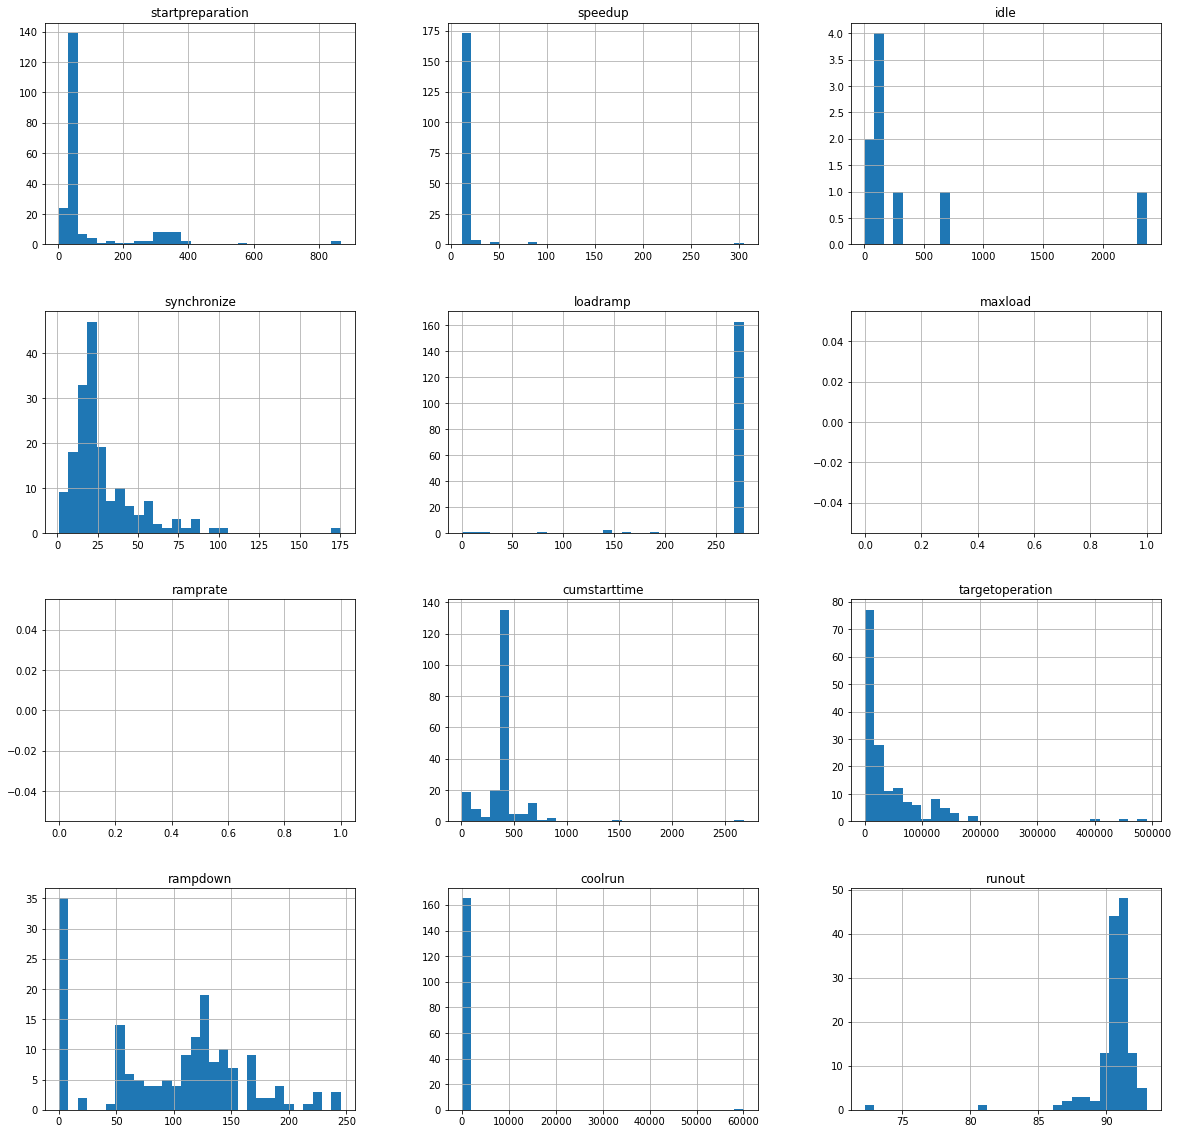

In [10]:
vec = ['startpreparation','speedup','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(_=rdb[vec].hist(bins=30,figsize=(20,20)))
#ax_list[0][2].set_xlim((0,10))
#display(rdb[vec].hist(bins=30,figsize=(20,20)))
display(rdb[vec].describe().round(2))

In [11]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success'])].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
dfigsize = (18,12)
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-20,300)},
    {'col':['startpreparation'],'ylim':(-600,1200)},
    {'col':['hochlauf'],'ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,3)},
    {'col':['no'],'ylim':(-100,10000),'color':'black'},
    {'col':['maxload'],'ylim':(500,5000) }
]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, style='both', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)

In [12]:
#vset = ['Various_Values_SpeedAct','Power_PowerAct','Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_PressOil','Hyd_TempOil']
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red', 'unit':'kW'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue', 'unit':'rpm'},
    {'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange', 'unit':'mbar'},
    {'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black', 'unit': 'bar'},
    {'col':['Hyd_PressOil'],'ylim': [0, 10], 'color':'brown', 'unit': 'bar'},
    {'col':['Hyd_TempOil','Hyd_TempCoolWat','Hyd_TempWatRetCoolOut'],'ylim': [0, 110], 'color':['#2171b5','orangered','hotpink'], 'unit':'°C'},
]
vset = cvset(mp,dset)

In [13]:
rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
63,63,False,AUTO,252.04,5.15,14.32,,1.21,277.78,550.50,,,47.35,0.61,91.07,,5,4
96,96,True,AUTO,60.34,6.18,14.31,,1.22,277.78,359.82,,,64427.92,120.32,0.0,91.3,0,0
125,125,True,AUTO,60.32,5.36,16.14,,1.22,277.78,360.81,,,35149.65,166.97,0.0,90.67,0,1
104,104,True,AUTO,60.48,5.34,14.64,,1.31,277.78,359.55,,,140283.84,114.18,0.0,91.22,0,0
69,69,True,AUTO,60.42,6.06,13.55,,1.31,277.78,359.12,,,2730.98,106.99,0.0,91.26,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,158,False,MANUAL,349.40,,,,,,349.40,,,,,,,1,0
159,159,False,MANUAL,349.08,,,,,,349.08,,,,,,,1,0
161,161,False,OFF,867.97,,,,,,867.97,,,,,,,0,0
163,163,False,MANUAL,294.68,,,,,,294.68,,,,,,,1,0


In [14]:
def f(x=0):
    global vv; vv = x; startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
    display(HTML(ftitle));
    disp_result(startversuch)
interact(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='90%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='90%'), max=211), Output()), _do…

HTML(value='1402507 HKW Pforzheim M01 ----- Start 0 AUTO | SUCCESS | 2021-07-06 06:56:04')

no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,True,AUTO,60.435,6.164,22.674,NaN,18.088999,277.776999,385.138998,NaN,NaN,369.299,0.505999,88.512,NaN,2,1


In [15]:
startversuch = rdb.iloc[vv]; 
#startversuch = rdb.iloc[900]; 

# download myplant data
data = get_cycle_data2(fsm, startversuch, max_length=1200, min_length=None, cycletime=1, silent=True, p_data=cvset(mp,dset))

# calculated data
data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))

fig = FSM_splot(fsm, startversuch, data, dset, figsize=(16,8))
fig = FSM_add_Notations(fig, fsm, startversuch)
bokeh_show(fig)

von: 06.07.2021 06:56:03 bis: 06.07.2021 07:10:07


In [16]:
def f(x=0):
    global vvv; vvv = x; startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
    display(HTML(ftitle));
    disp_result(startversuch)
interact(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='90%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='90%'), max=211), Output()), _do…

In [17]:
import bokeh
from bokeh.models import ColumnDataSource, Label, Text, Span, HoverTool #, Range1d#, LabelSet
from bokeh.plotting import figure, output_file, show

#startversuch = rdb.iloc[vvv];
periodfactor = 1.5 # times calculated period length
helplinefactor = 0.8 # overlay slope to -fac * end value 
#interestingcycles = [0,1,8, 62, 65, 76, 77, 80, 95, 96, 97, 98, 99, 252, 678] # BMW Landshut M4
#interestingcycles = [0,64, 66, 82] # Forsa Hartmoor M4
#interestingcycles = [0] # Pforzheim M4
interestingcycles = [17]
disp_result(rdb.iloc[interestingcycles[0]])

no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
17,False,OFF,90.575,NaN,NaN,NaN,NaN,NaN,90.575,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [18]:
startversuch;

In [19]:
def loadramp_edge_detect(startversuch):
    if 'loadramp' in startversuch['timing']:
        s = startversuch['timing']['loadramp'][-1]['start'].timestamp()
        e = startversuch['timing']['loadramp'][-1]['end'].timestamp()
        e2 = s + periodfactor * (e-s)
        data = load_data(fsm, cycletime=1, tts_from=s, tts_to=e2, silent=True, p_data=['Power_PowerAct'], p_forceReload=False)
        if not data.empty:
            data = data[(data['time'] >= int(s * 1000)) & (data['time'] <= int(e2 * 1000))]
            #s,e,e2, data.iloc[0]['time'], data.iloc[-1]['time'],
            x0 = data.iloc[0]['datetime']
            y0 = 0.0
            x1 = data.iloc[-1]['datetime']
            y1 = data.iloc[-1]['Power_PowerAct'] * helplinefactor
            data['helpline'] = data['Power_PowerAct'] + (x0 - data['datetime'])* (y1-y0)/(x1-x0) + y0

            edge = data.loc[data['helpline'].idxmax()]
            xmax = edge['datetime']
            ymax = data.at[edge.name,'Power_PowerAct']
        else:
            return pd.DataFrame([]), startversuch['endtime'], 0.0, 0.0, 0.0
    else:
        return pd.DataFrame([]), startversuch['endtime'], 0.0, 0.0, 0.0
    duration = xmax.timestamp()-s
    ramprate = ymax / duration
    return data, xmax, ymax, duration, ramprate    

In [21]:
import time
dset2 = [{'col':['Power_PowerAct','helpline'], 'ylim':(-1000,12000), 'color':['red','rgba(0,128,0,0.2)'], 'unit':'kW'},
         {'col':['power_diff','power_diff_help'], '_ylim':(0,5000), 'color':['rgba(255,0,0,0.2)','rgba(0,128,0,0.2)'], 'unit':'kW/s'}]
ratedload = fsm._e['Power_PowerNominal']
t0 = time.time()
for i, startversuch in rdb.iterrows() : 
    data, xmax, ymax, duration, ramprate = loadramp_edge_detect(startversuch)
    if not data.empty:
        print(f"Start: {startversuch['no']:3d} xmax: {xmax}, ymax: {ymax:6.0f}, duration: {duration:5.1f}, ramprate: {ramprate / ratedload * 100.0:4.2f} %/s")
        # data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
        # data['power_diff_help'] = pd.Series(np.gradient(data['helpline']))
        # fig = FSM_splot(fsm, startversuch, data, dset2, figsize=(14,6))
        # fig.add_layout(Span(location=0.0,dimension='width',x_range_name='default', y_range_name='0',line_color='black', line_dash='solid', line_alpha=0.4)) 
        # fig.add_layout(Span(location=ymax,dimension='width',x_range_name='default', y_range_name='0',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        # fig.add_layout(Span(location=xmax,dimension='height',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        # fig = FSM_add_Notations(fig, fsm, startversuch)
        # #fig = FSM_add_Alarms(fig, fsm, startversuch)
        # #fig = FSM_add_Warnings(fig, fsm, startversuch)
        # bokeh_show(fig)
    else:
        print(f"Start: {startversuch['no']:3d} no data, no improvement possible.")
t1 = time.time()
print(f"{(t1-t0):4.1f} sec")                

Start:   0 xmax: 2021-07-06 07:01:30, ymax:   7480, duration: 218.7, ramprate: 0.33 %/s
Start:   1 xmax: 2021-07-06 07:27:48, ymax:   7279, duration: 101.9, ramprate: 0.69 %/s
Start:   2 xmax: 2021-07-06 08:04:28, ymax:   9769, duration: 143.8, ramprate: 0.65 %/s
Start:   3 xmax: 2021-07-06 08:15:26, ymax:  10322, duration: 154.4, ramprate: 0.64 %/s
Start:   4 xmax: 2021-07-06 12:18:37, ymax:   9487, duration: 141.3, ramprate: 0.65 %/s
Start:   5 no data, no improvement possible.
Start:   6 no data, no improvement possible.
Start:   7 xmax: 2021-07-13 10:14:38, ymax:  10329, duration: 178.0, ramprate: 0.56 %/s
Start:   8 xmax: 2021-07-14 10:04:46, ymax:  10316, duration: 166.7, ramprate: 0.60 %/s
Start:   9 xmax: 2021-07-14 12:48:08, ymax:   5650, duration:  78.4, ramprate: 0.69 %/s
Start:  10 xmax: 2021-07-15 10:04:37, ymax:  10300, duration: 171.1, ramprate: 0.58 %/s
Start:  11 xmax: 2021-07-21 09:01:43, ymax:  10332, duration: 170.0, ramprate: 0.59 %/s
Start:  12 no data, no improve

In [ ]:
#for vk in interestingcycles: 
for vk in range(50): 
    startversuch = rdb.iloc[vk]; 
    #disp_result(startversuch)

    dset2 = [{'col':['Power_PowerAct','helpline'], 'ylim':(-1000,12000), 'color':['red','rgba(0,128,0,0.2)'], 'unit':'kW'},
            {'col':['power_diff','power_diff_help'], '_ylim':(0,5000), 'color':['rgba(255,0,0,0.2)','rgba(0,128,0,0.2)'], 'unit':'kW/s'}
            ]
    #vset2 = cvset(mp,dset2)

    if 'loadramp' in startversuch['timing']:
        s = startversuch['timing']['loadramp'][-1]['start'].timestamp()
        e = startversuch['timing']['loadramp'][-1]['end'].timestamp()
        e2 = s + periodfactor * (e-s)
        data = load_data(fsm, cycletime=1, tts_from=s, tts_to=e2, silent=False, p_data=['Power_PowerAct'], p_forceReload=True)
        if not data.empty:
            data = data[(data['time'] >= int(s * 1000)) & (data['time'] <= int(e2 * 1000))]
            #s,e,e2, data.iloc[0]['time'], data.iloc[-1]['time'],
            x0 = data.iloc[0]['datetime']
            y0 = 0.0
            x1 = data.iloc[-1]['datetime']
            y1 = data.iloc[-1]['Power_PowerAct'] * helplinefactor
            data['helpline'] = data['Power_PowerAct'] + (x0 - data['datetime'])* (y1-y0)/(x1-x0) + y0

            edge = data.loc[data['helpline'].idxmax()]
            xmax = edge['datetime']
            ymax = data.at[edge.name,'Power_PowerAct']
            print(xmax, ymax, xmax.timestamp()-s)

            data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
            data['power_diff_help'] = pd.Series(np.gradient(data['helpline']))
            fig = FSM_splot(fsm, startversuch, data, dset2, figsize=(14,6))
            fig.add_layout(Span(location=0.0,dimension='width',x_range_name='default', y_range_name='0',line_color='black', line_dash='solid', line_alpha=0.4)) 
            fig.add_layout(Span(location=ymax,dimension='width',x_range_name='default', y_range_name='0',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
            fig.add_layout(Span(location=xmax,dimension='height',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
            fig = FSM_add_Notations(fig, fsm, startversuch)
            #fig = FSM_add_Alarms(fig, fsm, startversuch)
            #fig = FSM_add_Warnings(fig, fsm, startversuch)
            bokeh_show(fig)
        else:
            print('no data found')
    else:
        print('loadramp state not reached.' )

In [ ]:
from dowork import plot_plotly
fig2 = plot_plotly(fsm, data, startversuch, cvset(mp,dset), dset, dfigsize=(15,9))
fig2.show(config={'scrollZoom': True})

In [ ]:
fsm.starts.iloc[vv].to_dict();

In [ ]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=True)):
    print(f"{i:3} {v}")

In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)